In [29]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV

In [30]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [31]:
df = pd.read_csv("bigData.csv")
print(df.shape)
df = df.drop_duplicates()

(10080, 14)


In [32]:
print(df.shape)

(8935, 14)


# Data cleaning 

In [33]:
df['Drivetrain'] = df['Drivetrain'].replace({
    'FWD - Dẫn động cầu trước': 'FWD',
    'AWD - 4 bánh toàn thời gian': 'AWD',
    'RFD - Dẫn động cầu sau': 'RFD',
    '4WD - Dẫn động 4 bánh': '4WD',
    '-': np.nan
})
df['YearOfManufacture'] = df['YearOfManufacture'].replace({
    '< 1990': np.nan
})

df['Doors'] = df['Doors'].replace({
    0: np.nan
})
df['Seats'] = df['Seats'].replace({
    0: np.nan
})
df['FuelType'] = df['FuelType'].replace({
    '-': np.nan
})
df['GearBox'] = df['GearBox'].replace({
    '-': np.nan
})


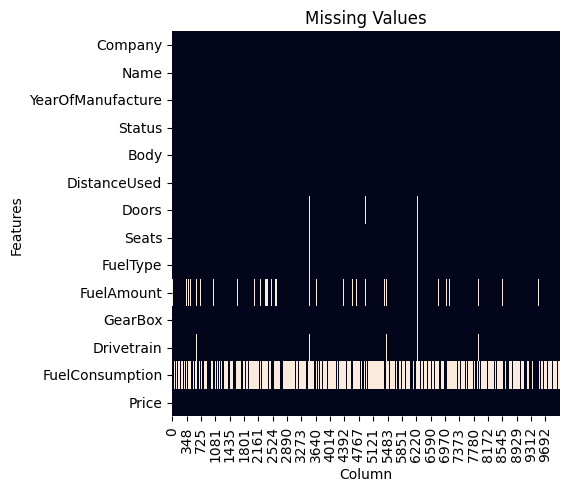

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df.isna().transpose(), cbar=False, ax=ax)
plt.title("Missing Values", fontsize=12)
plt.xlabel('Column', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.show()

Cột FuelConsumption miss rất nhiều giá trị -> ta nên drop cột này


In [35]:
df = df.drop(['FuelConsumption', 'Name'], axis=1)

In [36]:
X = df.drop('Price', axis=1)
y = df['Price']

_ Chia 3 tập train, test , validation theo tỉ lệ 80 10 10.

_ 3 tập này sẽ có cùng phân bố mẫu, điều này giúp đánh giá mô hình 1 cách công bằng và chính xác hơn

In [37]:
from verstack.stratified_continuous_split import scsplit
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
X_train, X_test, y_train, y_test = scsplit(X, y,stratify = y, random_state=2 ,test_size =0.3)


,Dataset,Mean Price (VND)
0,Training Set,"1,339,814,039"
1,Test Set,"1,324,236,852"


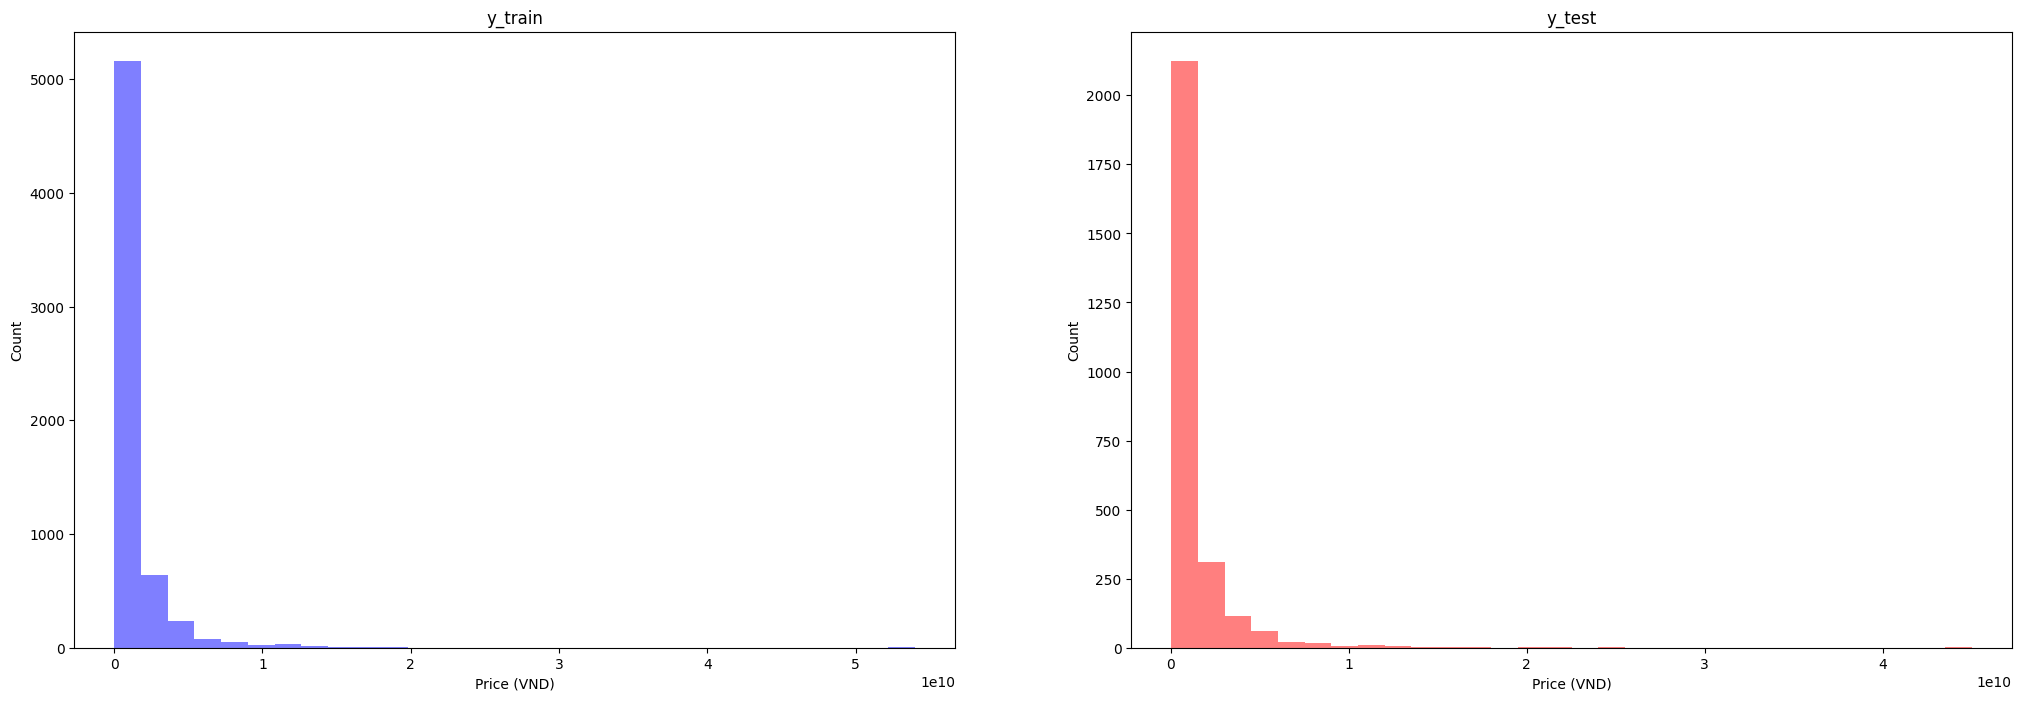

In [38]:
import matplotlib.pyplot as plt
# Tạo subplot và đặt kích thước hình
fig, axs = plt.subplots(1, 2, figsize=(25, 8))
styles = [
    dict(selector="th", props=[("text-align", "center")]),
    dict(selector="td", props=[("text-align", "center")])
]
# Thiết lập số lượng bins cho histogram
bins = 30

# Plot dữ liệu y_train
axs[0].hist(y_train, bins=bins, color='blue', alpha=0.5)
axs[0].set_title('y_train')
axs[0].set_xlabel('Price (VND)')
axs[0].set_ylabel('Count')

# Plot dữ liệu y_test
axs[1].hist(y_test, bins=bins, color='red', alpha=0.5)
axs[1].set_title('y_test')
axs[1].set_xlabel('Price (VND)')
axs[1].set_ylabel('Count')

# Đặt tên cho trục tung


# Tạo DataFrame từ dữ liệu trung bình
data = {
    'Dataset': ['Training Set', 'Test Set'],
    'Mean Price (VND)': [y_train.mean(), y_test.mean()]
}
df = pd.DataFrame(data)

# Định dạng DataFrame và hiển thị
formatted_df = df.round(2).style.format({'Mean Price (VND)': '{:,.0f}'})
formatted_df.set_table_styles(styles)
display(formatted_df)

_ Cả 3 tập này đều có cùng phân bố mẫu theo biến y 

_ Mean của 3 tập là gần bằng nhau

## Imputing missing value

In [39]:

CategoricalImputer = SimpleImputer(strategy='most_frequent')
columns_to_impute1 = ['Drivetrain', 'Company','FuelType','Status','Body','GearBox','Doors','Seats']
X_train[columns_to_impute1] = CategoricalImputer.fit_transform(X_train[columns_to_impute1])
X_test[columns_to_impute1] = CategoricalImputer.transform(X_test[columns_to_impute1])



In [40]:
NumericalImputer = SimpleImputer(missing_values=np.NaN,strategy='mean')
columns_to_impute2 = ['FuelAmount','YearOfManufacture','DistanceUsed']
X_train[columns_to_impute2] = NumericalImputer.fit_transform(X_train[columns_to_impute2])
X_test[columns_to_impute2] = NumericalImputer.transform(X_test[columns_to_impute2])



In [41]:
value_counts = X_train['Drivetrain'].value_counts()
fillvalue = 'AWD' if value_counts['AWD'] >= value_counts['4WD'] else '4WD'
X_train['Drivetrain'] = X_train['Drivetrain'].replace('4WD hoặc AWD', fillvalue)
X_test['Drivetrain'] = X_test['Drivetrain'].replace('4WD hoặc AWD', fillvalue)

print(fillvalue)


AWD


### Kết quả

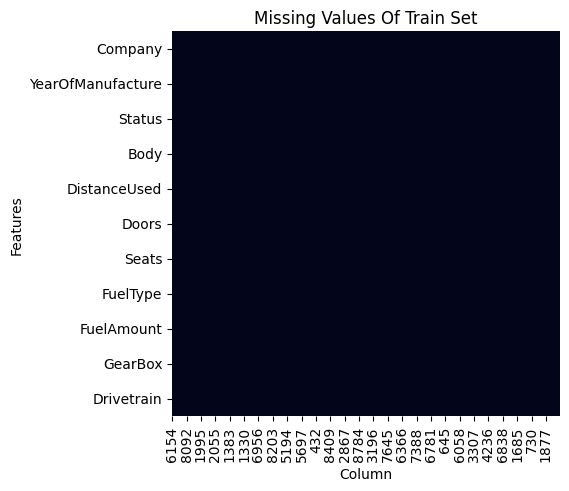

In [42]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(X_train.isna().transpose(), cbar=False, ax=ax)
plt.title("Missing Values Of Train Set", fontsize=12)
plt.xlabel('Column', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.show()

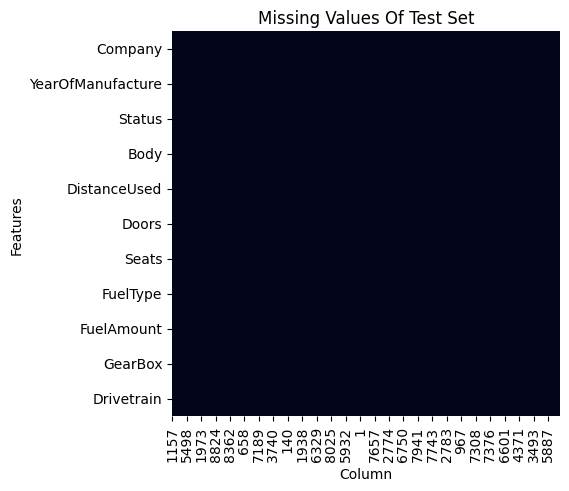

In [43]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(X_test.isna().transpose(), cbar=False, ax=ax)
plt.title("Missing Values Of Test Set", fontsize=12)
plt.xlabel('Column', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.show()

## Encoding

In [44]:
# Các biến đổi dữ liệu
onehot_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer_fueltype = OrdinalEncoder(categories=[['Xăng', 'Dầu', 'Hybrid','Điện']]) # Ứng với 0,1,2
ordinal_transformer_status = OrdinalEncoder(categories=[['used', 'new']]) # Ứng với 0,1
ordinal_transformer_gearbox = OrdinalEncoder(categories=[['Số tay', 'Số tự động', 'Số hỗn hợp']]) # Ứng với 0,1

# Xác định các cột dữ liệu cần được biến đổi và các biến đổi tương ứng
preprocessor = ColumnTransformer(
    transformers=[
        ('1hot', onehot_transformer, ['Drivetrain', 'Company', 'Body']),
        ('ordinal_fuel', ordinal_transformer_fueltype, ['FuelType']),
        ('ordinal_status', ordinal_transformer_status, ['Status']),
        ('ordinal_gearbox', ordinal_transformer_gearbox, ['GearBox'])
    ],
    remainder='passthrough'
)
# Encode lên 3 tập 
X_train_encoded = pd.DataFrame(preprocessor.fit_transform(X_train).toarray(), columns=preprocessor.get_feature_names_out())
X_test_encoded = pd.DataFrame(preprocessor.transform(X_test).toarray(), columns=preprocessor.get_feature_names_out())


In [45]:
X_train

,Company,YearOfManufacture,Status,Body,DistanceUsed,Doors,Seats,FuelType,FuelAmount,GearBox,Drivetrain
6154,Hyundai,2009.0,used,SUV,80000.0,5.0,7.0,Dầu,2.0,Số tự động,FWD
4799,Mercedes,2017.0,used,Sedan,65000.0,4.0,5.0,Xăng,2.0,Số tự động,RFD
6715,Honda,2023.0,new,Sedan,0.0,4.0,5.0,Xăng,1.5,Số tự động,FWD
4531,Kia,2019.0,used,Sedan,41000.0,4.0,5.0,Xăng,1.6,Số tay,FWD
5571,Lexus,2018.0,used,SUV,36000.0,5.0,5.0,Xăng,2.0,Số tự động,AWD
...,...,...,...,...,...,...,...,...,...,...,...
5066,Mercedes,2020.0,used,Sedan,39000.0,4.0,5.0,Xăng,3.0,Số tự động,RFD
8847,Mercedes,2020.0,used,Sedan,20000.0,4.0,5.0,Xăng,2.0,Số tự động,RFD
8750,Mercedes,2010.0,used,SUV,80000.0,5.0,7.0,Xăng,4.7,Số tự động,AWD
3645,Mercedes,2016.0,used,Sedan,70000.0,4.0,5.0,Xăng,2.0,Số tự động,RFD


In [46]:
print("X_train before Encode: ",X_train.shape)
print("X_train after Encode: ",X_train_encoded.shape)


X_train before Encode:  (6254, 11)
X_train after Encode:  (6254, 76)


In [47]:
print("X_test before Encode: ",X_test.shape)
print("X_test after Encode: ",X_test_encoded.shape)

X_test before Encode:  (2681, 11)
X_test after Encode:  (2681, 76)


In [48]:
X_train_encoded

,1hot__Drivetrain_4WD,1hot__Drivetrain_AWD,1hot__Drivetrain_FWD,1hot__Drivetrain_RFD,1hot__Company_Acura,1hot__Company_Aston,1hot__Company_Audi,1hot__Company_BMW,1hot__Company_Baic,1hot__Company_Bentley,...,1hot__Body_Van,1hot__Body_Wagon,ordinal_fuel__FuelType,ordinal_status__Status,ordinal_gearbox__GearBox,remainder__YearOfManufacture,remainder__DistanceUsed,remainder__Doors,remainder__Seats,remainder__FuelAmount
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,2009.0,80000.0,5.0,7.0,2.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2017.0,65000.0,4.0,5.0,2.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,2023.0,0.0,4.0,5.0,1.5
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2019.0,41000.0,4.0,5.0,1.6
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2018.0,36000.0,5.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6249,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2020.0,39000.0,4.0,5.0,3.0
6250,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2020.0,20000.0,4.0,5.0,2.0
6251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2010.0,80000.0,5.0,7.0,4.7
6252,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2016.0,70000.0,4.0,5.0,2.0


## Scaling

In [49]:
scaler = MinMaxScaler()
temp=X_train_encoded
X_train_scaled=scaler.fit_transform(X_train_encoded)
X_test_scaled=scaler.transform(X_test_encoded)


### Kết quả sau khi Scale:

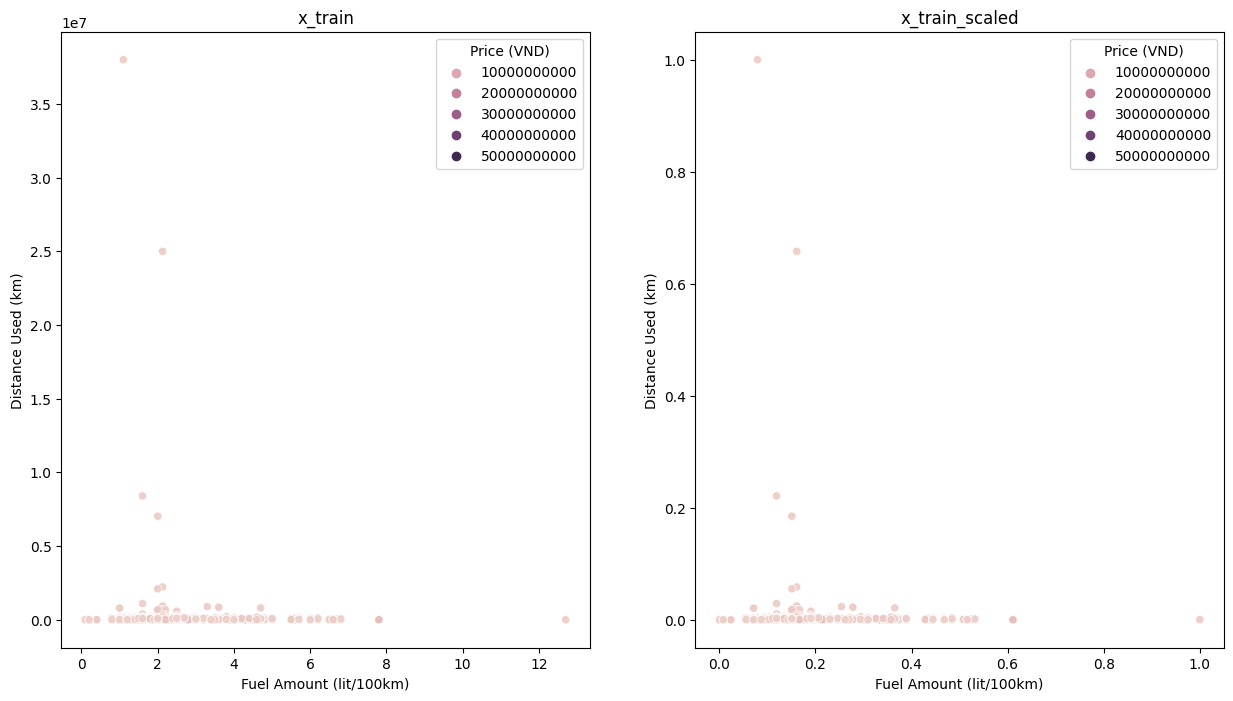

In [50]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)
y_train_copy=y_train.copy()
y_train_copy.rename('Price (VND)',inplace=True)
fig, axs = plt.subplots(ncols=2, figsize=(15,8))
sns.scatterplot(x='remainder__FuelAmount',y='remainder__DistanceUsed',data=X_train_encoded, hue=y_train_copy, ax=axs[0])
sns.scatterplot(x='remainder__FuelAmount',y='remainder__DistanceUsed',data= X_train_scaled,hue=y_train_copy, ax=axs[1])
axs[0].set_ylabel('Distance Used (km)')
axs[1].set_ylabel('Distance Used (km)')
axs[0].set_xlabel('Fuel Amount (lit/100km)')
axs[1].set_xlabel('Fuel Amount (lit/100km)')
axs[0].set_title("x_train")
axs[1].set_title("x_train_scaled")
plt.show()

_ Sau khi scale thì khoảng giá trị bị rút xuống còn [0,1]

# Feature Selection 

Thực hiện giảm số lượng Feature về 40 

In [51]:
n_features=40
select = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=n_features) #Tìm ra n đặc trưng tốt nhất
select.fit(X_train_scaled, y_train)
X_train_selected = select.transform(X_train_scaled) #Giảm số đặc trưng trên tập train
x_test_selected = select.transform(X_test_scaled) #Giảm số đặc trưng trên tập test
featureNames = temp.columns[select.get_support()]
print("Selected features: ",featureNames)

Selected features:  Index(['1hot__Drivetrain_4WD', '1hot__Drivetrain_AWD', '1hot__Drivetrain_FWD',
       '1hot__Drivetrain_RFD', '1hot__Company_Audi', '1hot__Company_BMW',
       '1hot__Company_Bentley', '1hot__Company_Ferrari', '1hot__Company_Ford',
       '1hot__Company_GMC', '1hot__Company_Hyundai', '1hot__Company_Jeep',
       '1hot__Company_Kia', '1hot__Company_Lamborghini',
       '1hot__Company_LandRover', '1hot__Company_Lexus',
       '1hot__Company_Lincoln', '1hot__Company_Maserati',
       '1hot__Company_McLaren', '1hot__Company_Mercedes', '1hot__Company_Mini',
       '1hot__Company_Porsche', '1hot__Company_Rolls', '1hot__Company_Subaru',
       '1hot__Company_Toyota', '1hot__Company_VinFast', '1hot__Company_Volvo',
       '1hot__Body_Bán tải ', '1hot__Body_Coupe', '1hot__Body_SUV',
       '1hot__Body_Sedan', '1hot__Body_Truck', 'ordinal_fuel__FuelType',
       'ordinal_status__Status', 'ordinal_gearbox__GearBox',
       'remainder__YearOfManufacture', 'remainder__Distance

List lưu giá trị RMSE, MAE và R2 score cho từng model

# Hyperparameter tuning 

## KNN

Tìm siêu tham số cho KNN

In [52]:
param_grid = {
    'n_neighbors': np.arange(1, 23, 1),
    'weights': ['distance', 'uniform'],
    'p': [1, 2, 3, 4, 5, 6]
}

grid_search_knn = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search_knn.fit(X_train_selected, y_train)

best_param_knn = grid_search_knn.best_params_
best_n_neighbors_knn = best_param_knn['n_neighbors']
best_weights_knn = best_param_knn['weights']
best_p_knn = best_param_knn['p']

print("\tKNN best params:", best_param_knn)

	KNN best params: {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


Đánh giá trên tập train và tập test

In [53]:
knn = KNeighborsRegressor(
    n_neighbors=best_n_neighbors_knn,
    weights=best_weights_knn,
    p=best_p_knn
)
knn.fit(X_train_selected, y_train) #Fit lại trên tập train

y_pred_knn_testset = knn.predict(x_test_selected) #Đánh giá trên tập test
rmse_knn_testset=mean_squared_error(y_test, y_pred_knn_testset, squared=False)
mae_knn_testset=mean_absolute_error(y_test, y_pred_knn_testset)
r2_knn_testset=(r2_score(y_test, y_pred_knn_testset))


y_pred_knn_trainset = knn.predict(X_train_selected) #Đánh giá trên tập train
rmse_knn_trainset=mean_squared_error(y_train, y_pred_knn_trainset, squared=False)
mae_knn_trainset=mean_absolute_error(y_train, y_pred_knn_trainset)
r2_knn_trainset=(r2_score(y_train, y_pred_knn_trainset))

## RFR

Tìm siêu tham số cho RFR

In [54]:
param_grid = {
    'n_estimators': [25,50, 100, 150,200,250,300,350],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9,12,15],
    'max_leaf_nodes': [3, 6, 9,12,15]
}
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search_rf.fit(X_train_selected, y_train)
best_param_rf = grid_search_rf.best_params_

best_n_estimators_rf = best_param_rf['n_estimators']
best_max_depth_rf = best_param_rf['max_depth']
best_max_features = best_param_rf['max_features']
best_max_leaf_nodes = best_param_rf['max_leaf_nodes']

print("\t", "rfr best param:", best_param_rf)


	 rfr best param: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 15, 'n_estimators': 150}


Đánh giá trên tập train và test

In [55]:
rf = RandomForestRegressor(
    n_estimators=best_n_estimators_rf,
    max_depth=best_max_depth_rf,
    max_features=best_max_features,
    max_leaf_nodes=best_max_leaf_nodes,
    random_state=42
)
#Đánh giá trên test set
rf.fit(X_train_selected, y_train)
y_pred_rf_testset = rf.predict(x_test_selected)
rmse_rf_testset=(mean_squared_error(y_test, y_pred_rf_testset, squared=False))
mae_rf_testset=(mean_absolute_error(y_test, y_pred_rf_testset))
r2_rf_testset=(r2_score(y_test, y_pred_rf_testset))


#Đánh giá tên tập train
y_pred_rf_trainset = rf.predict(X_train_selected)
rmse_rf_trainset = mean_squared_error(y_train, y_pred_rf_trainset, squared=False)
mae_rf_trainset = mean_absolute_error(y_train, y_pred_rf_trainset)
r2_rf_trainset = r2_score(y_train, y_pred_rf_trainset)





## LR

Đánh giá trên train và test

In [56]:
lr = LinearRegression()
lr.fit(X_train_selected, y_train)
# Đánh giá trên tập train
y_pred_lr_trainset = lr.predict(X_train_selected)
rmse_lr_trainset = mean_squared_error(y_train, y_pred_lr_trainset, squared=False)
mae_lr_trainset = mean_absolute_error(y_train, y_pred_lr_trainset)
r2_lr_trainset = r2_score(y_train, y_pred_lr_trainset)

# Đánh giá trên tập test
y_pred_lr_testset = lr.predict(x_test_selected)
rmse_lr_testset = mean_squared_error(y_test, y_pred_lr_testset, squared=False)
mae_lr_testset = mean_absolute_error(y_test, y_pred_lr_testset)
r2_lr_testset = r2_score(y_test, y_pred_lr_testset)

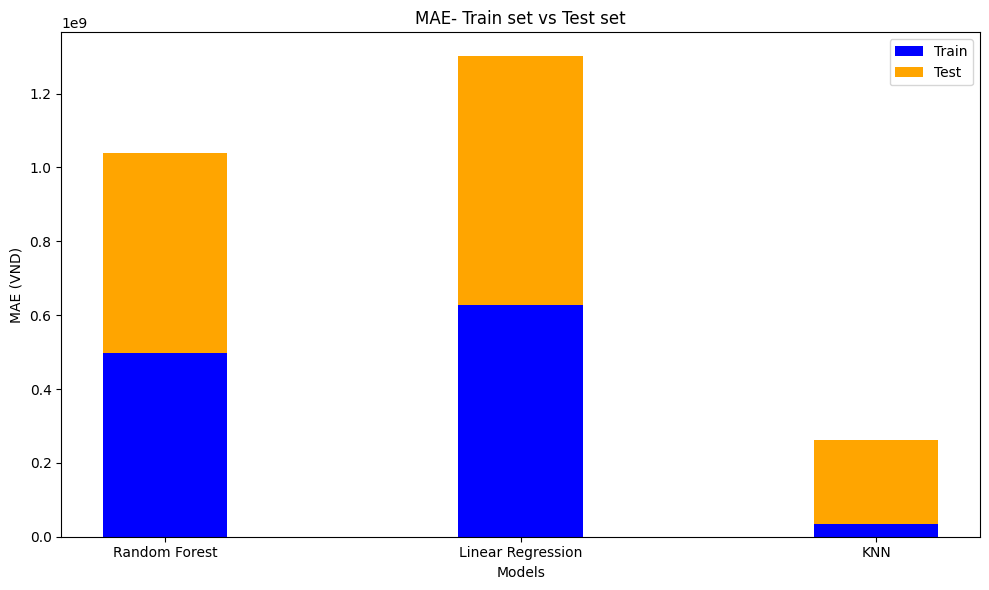

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# MAE trên tập train
mae_train = [mae_rf_trainset, mae_lr_trainset, mae_knn_trainset]

# MAE trên tập test
mae_test = [mae_rf_testset, mae_lr_testset, mae_knn_testset]

# Tên các mô hình
models = ['Random Forest', 'Linear Regression', 'KNN']

# Vẽ đồ thị
width = 0.35  # Độ rộng của mỗi thanh bar
x = np.arange(len(models))

plt.figure(figsize=(10, 6))

# Thanh bar màu xanh cho tập train
plt.bar(x, mae_train, width, label='Train', color='blue')

# Thanh bar màu cam cho tập test
plt.bar(x, mae_test, width, label='Test', color='orange', bottom=mae_train)

plt.xlabel('Models')
plt.ylabel('MAE (VND)')
plt.title('MAE- Train set vs Test set')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()

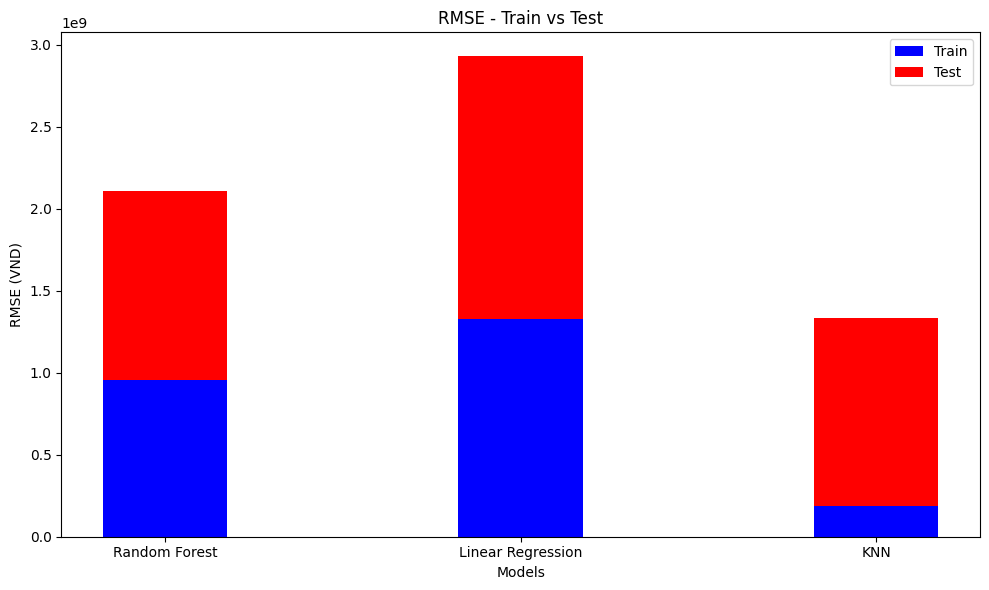

In [58]:
# RMSE trên tập train
rmse_train = [rmse_rf_trainset, rmse_lr_trainset, rmse_knn_trainset]

# RMSE trên tập test
rmse_test = [rmse_rf_testset, rmse_lr_testset, rmse_knn_testset]

# Tên các mô hình
models = ['Random Forest', 'Linear Regression', 'KNN']

# Vẽ đồ thị
width = 0.35  # Độ rộng của mỗi thanh bar
x = np.arange(len(models))

plt.figure(figsize=(10, 6))

# Thanh bar màu xanh cho tập train
plt.bar(x, rmse_train, width, label='Train', color='blue')

# Thanh bar màu đỏ cho tập test
plt.bar(x, rmse_test, width, label='Test', color='red', bottom=rmse_train)

plt.xlabel('Models')
plt.ylabel('RMSE (VND)')
plt.title('RMSE - Train vs Test')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()

# Đánh giá

Ở bước này ta lấy ra số feature tốt nhất và best hyperparameter của từng model đã tìm ở trên để đánh giá trên tập Test

### Bảng kết quả

Train set

In [59]:
model_names = ['KNN', 'Random Forest', 'Linear Regression']
mae_scores_train = [mae_knn_trainset, mae_rf_trainset, mae_lr_trainset]
rmse_scores_train = [rmse_knn_trainset, rmse_rf_trainset, rmse_lr_trainset]
r2_scores_train = [r2_knn_trainset, r2_rf_trainset, r2_lr_trainset]

# Tạo DataFrame
df_scores = pd.DataFrame({
    'Model': model_names,
    'MAE (VND)': mae_scores_train,
    'RMSE (VND)': rmse_scores_train,
    'R2': r2_scores_train
})
df_scores_styled = df_scores.style.format({
    'MAE (VND)': "{:,.0f}",
    'RMSE (VND)': "{:,.0f}",
    'R-squared': '{:.3f}'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])
df_scores_styled

,Model,MAE (VND),RMSE (VND),R2
0,KNN,"35,123,761","188,925,189",0.992903
1,Random Forest,"498,396,988","954,386,479",0.818885
2,Linear Regression,"628,140,438","1,329,470,824",0.648550


Test set

In [60]:
mae_scores = [mae_knn_testset, mae_rf_testset, mae_lr_testset]
rmse_scores = [rmse_knn_testset, rmse_rf_testset, rmse_lr_testset]
r2_scores = [r2_knn_testset, r2_rf_testset, r2_lr_testset]

# Tạo DataFrame
df_scores = pd.DataFrame({
    'Model': model_names,
    'MAE (VND)': mae_scores,
    'RMSE (VND)': rmse_scores,
    'R2': r2_scores
})
df_scores_styled = df_scores.style.format({
    'MAE (VND)': "{:,.0f}",
    'RMSE (VND)': "{:,.0f}",
    'R-squared': '{:.3f}'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])
df_scores_styled

,Model,MAE (VND),RMSE (VND),R2
0,KNN,"225,684,819","1,147,504,270",0.699046
1,Random Forest,"541,216,133","1,154,770,310",0.695223
2,Linear Regression,"672,655,866","1,600,585,802",0.414470


# Nhận xét

- 2 model KNN và Random Forest bị overfitting. Còn LR thì bị underfitting
-  So sánh giữa KNN và RF:

   _ Trên train data set, KNN cho ra R2 cao và MAE, RMSE thấp hơn -> KNN hoạt động trên train tốt hơn

   _ Trên test data set, mặc dù MAE của RF cao hơn so với của KNN, nhưng RMSE của RF thấp hơn và R2 của nó cũng cao hơn so với KNN -> RF hoạt động tốt hơn trên test
   
- Cả 3 mô hình hoạt động còn khá tệ -> không thể nào đưa vào sử dụng thực tế

   Giải thích

   _ Có thể việc chưa xử lý ngoại lệ, nhiễu -> ảnh hưởng đến khả năng dự đoán của mô hình

   _ Dữ liệu thu thập từ web là dữ liệu mang tính định tính, không đáng tin cậy 

   _ Phân bố mẫu tập train và test vẫn còn khá khác nhau -> đánh giá không công bằng và chính xác

   _ Có lẽ số đặc trưng được lựa chọn chưa đủ tối ưu với mỗi mô hình




